# Day 08. Exercise 02
# Multiclass classification. One-hot encoding. Random forest

## 0. Imports

In [2]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt


## 1. Preprocessing

1. Read the file [`checker-submits.csv`](https://drive.google.com/file/d/14voc4fNJZiLEFaZyd8nEG-lQt5JjatYw/view?usp=sharing).
2. Create a dataframe `df` with the columns: `uid`, `labname`, `numTrials`, `hour`, `dayofweek` where `hour` is extracted from the `timestamp` as well as the `dayofweek` (`0` is Monday, `6` is Sunday). We will try to predict the day of the week having data about which user made a commit for which lab at which hour and which try it was.
3. Using `OneHotEncoder()` transform your categorical features, delete from the dataframe the initial columns.
4. Use `StandardScaler()` and scale your continuous features.
5. Save the dataframe as `dayofweek.csv`.
6. Before trying out different algorithms, find out the accuracy of the naive algorithms – the one that predicts everything as the most popular class.

In [3]:
df = pd.read_csv('../../data/checker_submits.csv', parse_dates=["timestamp"])

In [4]:
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.day_of_week
df.drop(axis=1, labels = ['timestamp'], inplace = True)

In [5]:
one_hot_enc = OneHotEncoder(sparse_output=False).set_output(transform='pandas')
ohe_df = one_hot_enc.fit_transform(df[['uid', 'labname']])
df = pd.concat([df, ohe_df], axis = 1).drop(axis =1, labels=['uid', 'labname'])

In [6]:
std_scaler = StandardScaler()
df['numTrials'] = std_scaler.fit_transform(df[['numTrials']])
df['hour'] = std_scaler.fit_transform(df[['hour']])

In [7]:
df.to_csv('../../data/dayofweek.csv', index=False)

In [8]:
accuracy_score(df['dayofweek'], [df['dayofweek'].mode().iloc[0] for i in range(0, len(df['dayofweek']))])

0.23487544483985764

## 2. Algorithms

### a. Logreg

1. Train logistic regression, for the baseline model use `random_state=21`, `fit_intercept=False`. 
2. Calculate the accuracy.
3. Write a function that draws the plot (`barh`) taking coefficients of any trained models, names of the features and the number of `top-n` most important features to display.
4. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model.
5. Remember that it is a multiclass classification and `coef_` returns a matrix, to calculate importance for a feature you need to sum all the individual feature importances for all the target values.

In [9]:
log_reg = LogisticRegression(random_state=21, fit_intercept=False, solver='liblinear')
log_reg.fit(df.drop(axis=1, labels = ['dayofweek']), df['dayofweek'])

LogisticRegression(fit_intercept=False, random_state=21, solver='liblinear')

In [10]:
accuracy_score(
    df['dayofweek'],
    log_reg.predict(df.drop(axis=1, labels = ['dayofweek']))
)

0.6215895610913404

In [11]:
def barh(coef:list, names:list, n:int):
    coef_df = pd.DataFrame(coef, names, columns=['weight'])
    coef_df.sort_values(by='weight', inplace=True, ascending=False)
    coef_df = coef_df.iloc[:n]
    coef_df.plot(kind='barh')

In [12]:
coef_list = np.zeros(len(log_reg.coef_[0]))
for cls in log_reg.coef_:
    coef_list = coef_list + np.abs(cls)


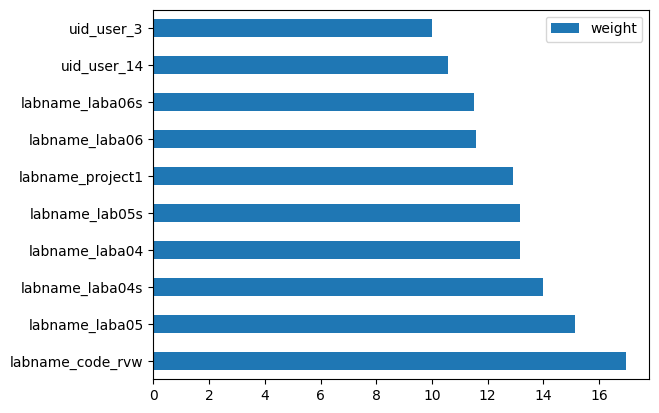

In [13]:
barh(coef=coef_list, names=df.drop(axis=1, labels = ["dayofweek"]).columns, n=10)

чеклист кринж)))

### b. SVC

1. Train a `SVC` model, for the baseline model use parameters `kernel='linear'`, `probability=True`, `random_state=21`. 
2. Try different kernels, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model for the linear kernel *

*By default SVC uses “one vs one” strategy of the classification, thus in `coef_` it returns a matrix. To calculate importance for a feature you need to use [OneVsRestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) over the SVC and sum all the individual feature importances for all the target values.

In [14]:
svc_reg = SVC(kernel='linear', probability=True, random_state=21)

In [15]:
svc_reg.fit(df.drop(axis=1, labels = ['dayofweek']), df['dayofweek'])

SVC(kernel='linear', probability=True, random_state=21)

In [16]:
accuracy_score(
    df['dayofweek'],
    svc_reg.predict(df.drop(axis=1, labels = ['dayofweek']))
)

0.702846975088968

In [17]:
ovr = OneVsRestClassifier(estimator=svc_reg)

In [18]:
ovr.fit(df.drop(axis=1, labels = ['dayofweek']), df['dayofweek'])

OneVsRestClassifier(estimator=SVC(kernel='linear', probability=True,
                                  random_state=21))

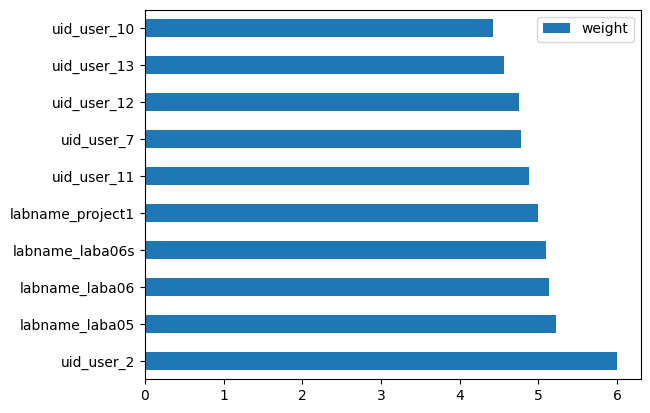

In [19]:
l = np.array([0.0 for i in range(0, len(ovr.estimators_[0].coef_))])
for est in ovr.estimators_:
   l = l + np.abs(est.coef_[0])
barh(coef=l, names=df.drop(axis=1, labels = ["dayofweek"]).columns, n=10)

### c. Decision tree

1. Train a `DecisionTreeClassifier` using for the baseline model `max_depth=4`, `random_state=21`. 
2. Try different values of `max_depth`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [20]:
tree_reg = DecisionTreeClassifier(max_depth=4, random_state=21)

In [21]:
tree_reg.fit(df.drop(axis=1, labels=['dayofweek']), df['dayofweek'])

DecisionTreeClassifier(max_depth=4, random_state=21)

In [22]:
accuracy_score(df['dayofweek'], tree_reg.predict(df.drop(axis=1, labels=['dayofweek'])))

0.5516014234875445

In [23]:
for d in range(1, 15):
    tr = DecisionTreeClassifier(max_depth=d, random_state=21)
    tr.fit(df.drop(axis=1, labels=['dayofweek']), df['dayofweek'])
    acc = accuracy_score(df['dayofweek'], tr.predict(df.drop(axis=1, labels=['dayofweek'])))
    print(d, '|', acc)
    print('-' * 25)

1 | 0.35765124555160144
-------------------------
2 | 0.4389086595492289
-------------------------
3 | 0.48991696322657174
-------------------------
4 | 0.5516014234875445
-------------------------
5 | 0.6109134045077106
-------------------------
6 | 0.6637010676156584
-------------------------
7 | 0.7064056939501779
-------------------------
8 | 0.7502965599051008
-------------------------
9 | 0.7846975088967971
-------------------------
10 | 0.8196915776986952
-------------------------
11 | 0.8499406880189798
-------------------------
12 | 0.8831553973902728
-------------------------
13 | 0.9104389086595492
-------------------------
14 | 0.9317912218268091
-------------------------


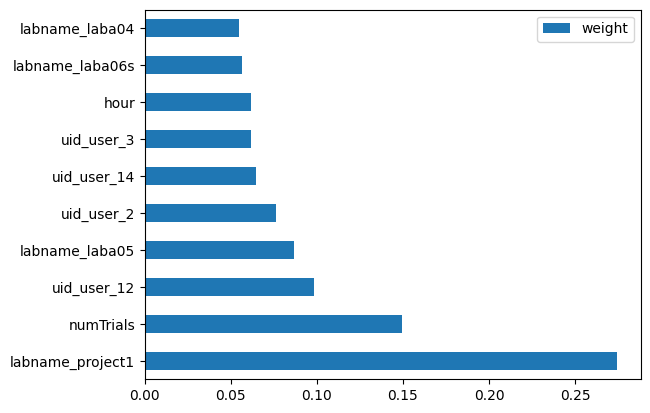

In [24]:
barh(coef=tree_reg.feature_importances_, names=df.drop(axis=1, labels = ["dayofweek"]).columns, n=10)

### d. Random forest

In real life forest is a set of trees. The same thing is with machine learning. Random forest is a set of individual decision trees (check the documentation for more details).

1. Train a `RandomForestClassifier` using for the baseline model parameters `n_estimators=100`, `max_depth = 25`, `random_state=21`. 
2. Try different values of `max_depth` and `n_estimators`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [25]:
forest_reg = RandomForestClassifier(n_estimators=100, max_depth=25, random_state=21)

In [26]:
forest_reg.fit(df.drop(axis=1, labels=['dayofweek']), df['dayofweek'])

RandomForestClassifier(max_depth=25, random_state=21)

In [27]:
accuracy_score(df['dayofweek'], forest_reg.predict(df.drop(axis=1, labels=['dayofweek'])))

1.0

In [28]:
for max_d in range(1, 5, 1):
    for n_est in range(1, 15, 5):
        forest_reg_g = RandomForestClassifier(n_estimators=100, max_depth=25, random_state=21)
        forest_reg_g.fit(df.drop(axis=1, labels=['dayofweek']), df['dayofweek'])
        acc = accuracy_score(df['dayofweek'], forest_reg_g.predict(df.drop(axis=1, labels=['dayofweek'])))
        print(max_d, '|', n_est, '|', acc)
        print('-'*25)

1 | 1 | 1.0
-------------------------
1 | 6 | 1.0
-------------------------
1 | 11 | 1.0
-------------------------
2 | 1 | 1.0
-------------------------
2 | 6 | 1.0
-------------------------
2 | 11 | 1.0
-------------------------
3 | 1 | 1.0
-------------------------
3 | 6 | 1.0
-------------------------
3 | 11 | 1.0
-------------------------
4 | 1 | 1.0
-------------------------
4 | 6 | 1.0
-------------------------
4 | 11 | 1.0
-------------------------


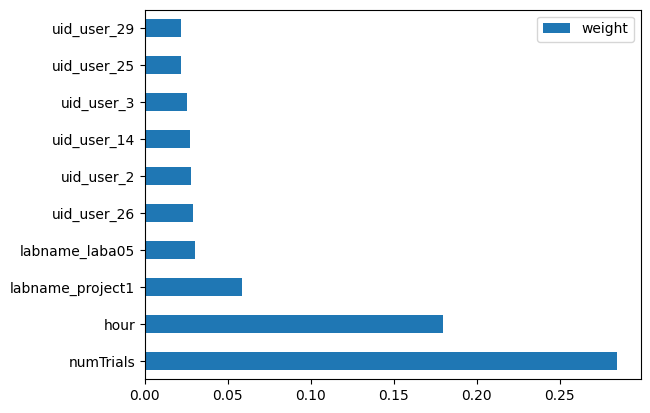

In [29]:
barh(coef=forest_reg.feature_importances_, names=df.drop(axis=1, labels = ["dayofweek"]).columns, n=10)